In [2]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

N = 256

def WaveIteration(u, v, dt):
    i,j = u.indices
    laplacian = u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - u * 4.0
    force = laplacian - 0.08 * tf.sin(2.0*np.pi*u)
    v_new = v + dt*force
    u_new = u + dt*v_new
    return u_new, v_new

def WaveEq():
    u = tf.input([-1, -1], tf.float32)
    v = tf.input([-1, -1], tf.float32)

    u,v = WaveIteration(u, v, 0.15)

    return [u, v]

tf.initialize(tf.cpu, "H:/tinycc/win32/tcc.exe")
test = tf.program(WaveEq)


TensorFrost module loaded!
dim =  2


In [2]:
#intialize as a gaussian pulse in the middle
Anp = np.zeros((N, N))
Bnp = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        Anp[i, j] = np.exp(-((i-N/3)**2 + (j-N/3)**2)/10)

A = tf.memory(Anp)
B = tf.memory(Bnp)
A, B = test(A, B)

print("Used memory: " + str(tf.used_memory()))

Used memory: 262148


In [3]:
#do a few steps and measure performance by timing every 100 steps
import time
start = time.time()

print("Used memory: " + str(tf.used_memory()))

for i in range(2000):
    A, B = test(A, B)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()

print("Used memory: " + str(tf.used_memory()))

Used memory: 262148
Iterations per second: 120.91889392312721
Iterations per second: 120.91913794420653
Iterations per second: 120.04809589871125
Iterations per second: 119.76040517999022
Iterations per second: 119.47429423696524
Iterations per second: 119.33176777456409
Iterations per second: 118.2032491982968
Iterations per second: 117.78560025161718
Iterations per second: 117.37095797030679
Iterations per second: 117.64707202317541
Iterations per second: 117.37105650360343
Iterations per second: 117.09597349143773
Iterations per second: 117.50880341619336
Iterations per second: 117.78566640540775
Iterations per second: 117.5087704946049
Iterations per second: 117.78556717474977
Iterations per second: 117.78563332850318
Iterations per second: 117.7856994823309
Iterations per second: 117.92448825071955
Iterations per second: 117.78563332850318
Used memory: 262148


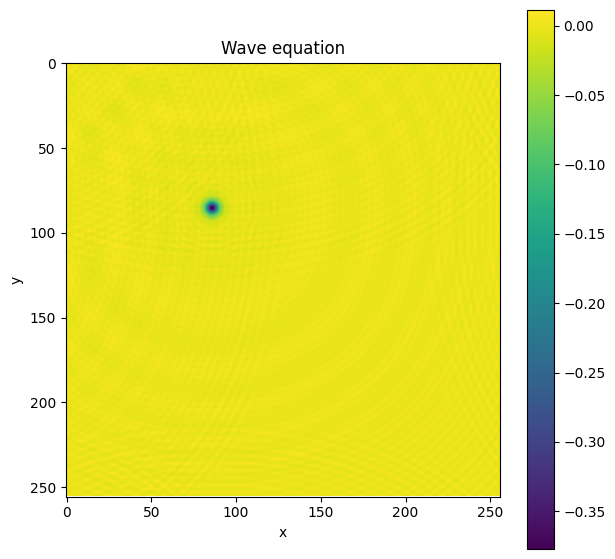

In [4]:
# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(A.numpy)
plt.colorbar()
plt.title("Wave equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()



In [5]:
# Poisson equation solver test
# source term is a point source in the middle

def PoissonStep():
    u = tf.input([-1, -1], tf.float32)
    f = tf.input([-1, -1], tf.float32)

    i,j = u.indices

    u = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] - f[i, j]) / 4.0

    return [u]

poisson = tf.program(PoissonStep)

dim =  2


Iterations per second: 235.84904281131477
Iterations per second: 232.018949606747
Iterations per second: 232.55823237503813
Iterations per second: 233.10002789883947
Iterations per second: 232.55810343039926
Iterations per second: 233.64253166813356
Iterations per second: 233.10248930301628
Iterations per second: 233.64487439016645
Iterations per second: 232.0172811028043
Iterations per second: 232.01997639033178


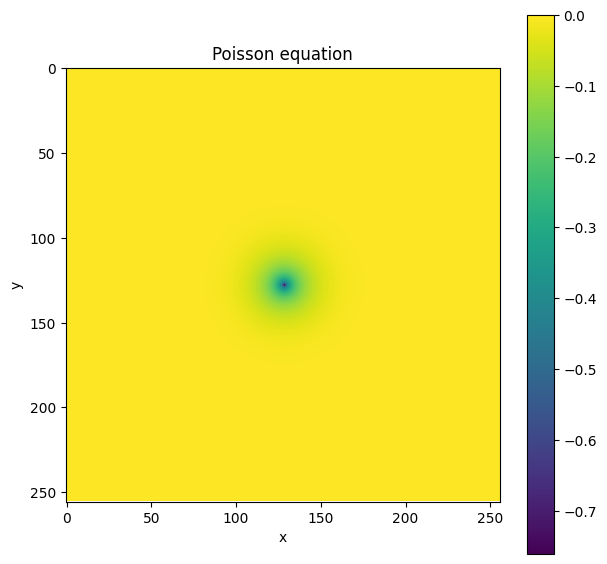

In [6]:
N = 256

#intialize as a gaussian pulse in the middle
Fnp = np.zeros((N, N))
Fnp[N//2, N//2] = 1.0

F = tf.memory(Fnp)
U = tf.memory(np.zeros((N, N)))

#do a few steps and measure performance by timing every 100 steps
start = time.time()

for i in range(1000):
    U, = poisson(U, F)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()

# Plot the results (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(U.numpy)
plt.colorbar()
plt.title("Poisson equation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
poisson.kernel_c()

#include <math.h> 
typedef unsigned int uint; 

float asfloat(uint x) 
{ 
  return *(float*)&x; 
} 

uint asuint(float x) 
{ 
  return *(uint*)&x; 
} 

int clamp(int x, int min, int max) 
{ 
  if(x < min) return min; 
  if(x > max) return max; 
  return x; 
} 

void kernel_0(uint* variables, uint* offsets, uint* memory, uint thread_id)
{
  int var1_0 = thread_id;
  int var1_2 = 1 * variables[0];
  int var1_3 = var1_0 / var1_2;
  int var1_5 = var1_0 / 1;
  int var1_6 = var1_5 % variables[1];
  int var1_8 = var1_6 - 1;
  int var1_10 = var1_6 + 1;
  int var1_12 = variables[2] - 1;
  int var1_14 = clamp(var1_3, 0, var1_12);
  int var1_15 = var1_14 * variables[3];
  int var1_17 = variables[4] - 1;
  int var1_19 = clamp(var1_8, 0, var1_17);
  int var1_20 = var1_15 + var1_19;
  float var1_21 = asfloat(memory[offsets[0] + var1_20]);
  int var1_23 = variables[5] - 1;
  int var1_25 = clamp(var1_3, 0, var1_23);
  int var1_26 = var1_25 * variables[6];
  int var1_28 = variables[7] - 1;
  int var1_3

In [1]:
import TensorFrost as tf
import numpy as np
import matplotlib.pyplot as plt
import time

N = 256

def Bilinear(tex, x, y):
    xi = tf.floor(x)
    yi = tf.floor(y)
    xf = x - xi
    yf = y - yi
    xi = tf.int(xi)
    yi = tf.int(yi)
    return (1.0-xf)*(1.0-yf)*tex[xi, yi] + xf*(1.0-yf)*tex[xi+1, yi] + (1.0-xf)*yf*tex[xi, yi+1] + xf*yf*tex[xi+1, yi+1]

def FluidTest():
    vx = tf.input([N, N], tf.float32)
    vy = tf.input([N, N], tf.float32)
    density = tf.input([N, N], tf.float32)
    pressure = tf.input([N, N], tf.float32)

    dt = 0.1

    # advect velocity
    i,j = vx.indices
    x, y = tf.float(i), tf.float(j)
    x1, y1 = x - vx*dt, y - vy*dt

    vx = Bilinear(vx, x1, y1)
    vy = Bilinear(vy, x1, y1)
    density = Bilinear(density, x1, y1)
    
    # add source
    source = tf.exp(-((x-N/3.0)**2.0 + (y-N/3.0)**2.0)/10.0)
    density = density + source
    vx = vx + source

    # compute divergence
    div = vx[i+1, j] - vx[i-1, j] + vy[i, j+1] - vy[i, j-1]

    # pressure solve
    for i in range(1):
        pressure = (pressure[i-1, j] + pressure[i+1, j] + pressure[i, j-1] + pressure[i, j+1] - div) / 4.0
    
    # subtract pressure gradient
    vx = vx - (pressure[i+1, j] - pressure[i-1, j]) / 2.0
    vy = vy - (pressure[i, j+1] - pressure[i, j-1]) / 2.0

    return [vx, vy, density, pressure]

tf.initialize(tf.cpu, "C:/msys64/mingw64/bin/gcc.exe")
fluid = tf.program(FluidTest)



TensorFrost module loaded!
dim =  2


In [2]:
VX = tf.memory(np.zeros((N, N)))
VY = tf.memory(np.zeros((N, N)))
DENSITY = tf.memory(np.zeros((N, N)))
PRESSURE = tf.memory(np.zeros((N, N)))

#do a few steps and measure performance by timing every 100 steps
start = time.time()

for i in range(100):
    VX, VY, DENSITY, PRESSURE = fluid(VX, VY, DENSITY, PRESSURE)
    if i % 100 == 99:
        print("Iterations per second: " + str(100/(time.time()-start)))
        start = time.time()


: 

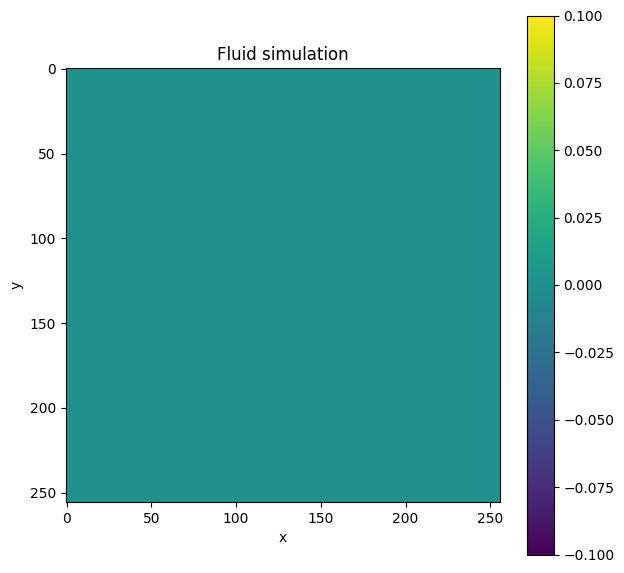

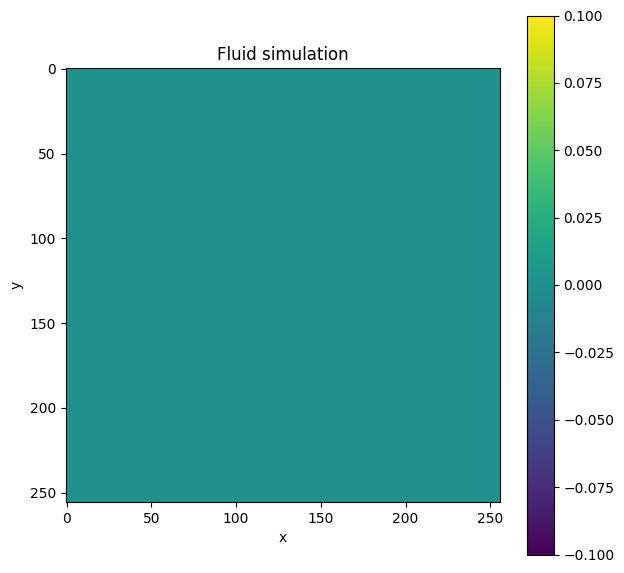

In [3]:
# Plot the density (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(DENSITY.numpy)
plt.colorbar()
plt.title("Fluid simulation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# Plot the velocity (with colorbar)
plt.figure(figsize=(7,7))
plt.imshow(VX.numpy)
plt.colorbar()
plt.title("Fluid simulation")
plt.xlabel("x")
plt.ylabel("y")
plt.show()